# What happens in this notebook :-)

* We read in MC samples for background and different signal models. We also read in the actual data from the L3 detector.

* We load the pickel file of the trained BDT and select our events according to some cut on the BDT response.

* The selected candidates passing the BDT cut as well as the cut MC samples are stored and used for the 2D analysis in Higgs@L3-2D.ipynb.

* A 1D log-Likelihood ratio analysis is performed.

* Quantile plots are produced


### import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']


\begin{array}{|l||c|c|c|c|}
\hline
\textrm{sample name} & \textrm{type of data} & \textrm{real data} & \textrm{No. of events} & \sigma   [\textrm{pb}] \\ \hline
\textrm{higgs_qq} & q \bar{q} & - & 200000 & 102 \\ \hline
\textrm{higgs_ww} & W^+ W^- & - & 294500 & 16.5 \\ \hline
\textrm{higgs_zz} & ZZ & - & 196000 & 0.975 \\ \hline
\textrm{higgs_zee} & Z e^+ e^- & - & 29500 & 3.35 \\ \hline
\textrm{higgs_wen} & q \bar{q} e \nu_e & - & 81786 & 2.90 \\ \hline
\textrm{higgs_eeqq} & \textrm{two photon coll} & - & 5940000 & 15600 \\ \hline
\textrm{higgs_data} & \textrm{data} & x & - & - \\ \hline
\textrm{higgs_higgs_85} & \textrm{Higgs} (m_{H} = 85 \ \textrm{GeV}) & - & 3972 & 0.0940\\ \hline
\textrm{higgs_higgs_90} & \textrm{Higgs} (m_{H} = 90 \ \textrm{GeV}) & - & 3973 & 0.0667\\ \hline
\textrm{higgs_higgs_95} & \textrm{Higgs} (m_{H} = 95 \ \textrm{GeV}) & - & 3971 & 0.0333\\ \hline	
\end{array}

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [3]:
# load classifier
import cPickle
from sklearn.tree import DecisionTreeClassifier

with open('BDT_85higgs1.pkl', 'rb') as fid:
    BDT_85 = cPickle.load(fid)

with open('BDT_90higgs4.pkl', 'rb') as fid:
    BDT_90 = cPickle.load(fid)

with open('BDT_95higgs3.pkl', 'rb') as fid:
    BDT_95 = cPickle.load(fid)
    
print BDT_85.get_params  
print BDT_90.get_params  
print BDT_95.get_params  


<bound method GradientBoostingClassifier.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)>
<bound method GradientBoostingClassifier.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)>
<bound method GradientBoosting

In [4]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = ['btag1','btag2','ucsdbt0','acthm','mvissc','mmis']+['class','weight']
    discriminating_vars = ['ucsdbt0','acthm','mvissc','mmis','xmj1','acop']+['class','weight']
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']
    return df[discriminating_vars]

In [5]:
def KillVars (df) :
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']+['weight']
    return df[discriminating_vars]

In [6]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame['BDT_selCut85'] = BDT_85.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut90'] = BDT_90.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut95'] = BDT_95.decision_function(PickDiscVar_mH85(df=frame))

#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame['BDT_selCut85'] = BDT_85.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut90'] = BDT_90.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut95'] = BDT_95.decision_function(PickDiscVar_mH85(df=frame))

#add column 'weight'=1 to data 
data["weight"] = 1
data['BDT_selCut85'] = BDT_85.decision_function(PickDiscVar_mH85(df=data))
data['BDT_selCut90'] = BDT_90.decision_function(PickDiscVar_mH85(df=data))
data['BDT_selCut95'] = BDT_95.decision_function(PickDiscVar_mH85(df=data))


In [7]:
cut_85 = -3.15
cut_90 = -2.9
cut_95 = -2.9

In [8]:
df_bkg = pd.concat(framesMC_NoHiggs)

In [9]:
data_85 = KillVars(data[data['BDT_selCut85']>cut_85])
data_90 = KillVars(data[data['BDT_selCut90']>cut_90])
data_95 = KillVars(data[data['BDT_selCut95']>cut_95])

sig_85 = KillVars(framesMC_HiggsModels[0][framesMC_HiggsModels[0]['BDT_selCut85']>cut_85])
sig_90 = KillVars(framesMC_HiggsModels[1][framesMC_HiggsModels[1]['BDT_selCut90']>cut_90])
sig_95 = KillVars(framesMC_HiggsModels[2][framesMC_HiggsModels[2]['BDT_selCut95']>cut_95])

bkg_85 = KillVars(df_bkg[df_bkg['BDT_selCut85']>cut_85])
bkg_90 = KillVars(df_bkg[df_bkg['BDT_selCut90']>cut_90])
bkg_95 = KillVars(df_bkg[df_bkg['BDT_selCut95']>cut_95])


In [10]:
# purity in range 90 +- 5 GeV

sig_in_interval = sig_90[(sig_90['mmis']<95)&(sig_90['mmis']>85)]['weight'].sum()
bkg_in_interval = bkg_90[(bkg_90['mmis']<95)&(bkg_90['mmis']>85)]['weight'].sum()

purity = sig_in_interval*1. / bkg_in_interval

print purity
print len(data_90['weight'])

0.397343881101
27


In [18]:
data_85.to_csv('data_85')
data_90.to_csv('data_90')
data_95.to_csv('data_95')

sig_85.to_csv('sig_85')
sig_90.to_csv('sig_90')
sig_95.to_csv('sig_95')

bkg_85.to_csv('bkg_85')
bkg_90.to_csv('bkg_90')
bkg_95.to_csv('bkg_95')

### distribution of variable of interest

In [11]:
def GetHistogram (df, column, binning) :
  
    return np.histogram(a=df[column],
                        bins = binning,
                        weights=df['weight'])[0]

In [12]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [13]:
path = '/home/janik/StatMethods/Project/plots/VariableDists/'
#ensure_dir(file_path=path)
variable = 'mmis'
x_name = r'missing mass $m_\mathrm{mis}$ '
x_unit = r'GeV/$c^2$'
binning = np.array([50,60,70,80,85,90,95,100,105,110,120,140])
binning = np.linspace(50,130,28)
#binning = np.linspace(75,100,28)
save_path = None#path+variable

In [14]:
bkg_histos = []
sig_histos = []
data_histos = []

for frame in [bkg_85,bkg_90,bkg_95] :
    bkg_histos.append(GetHistogram(df=frame,column=variable,binning=binning))

for frame in [sig_85,sig_90,sig_95] :
    sig_histos.append(GetHistogram(df=frame,column=variable,binning=binning))

for frame in [data_85,data_90,data_95] :
    data_histos.append(GetHistogram(df=frame,column=variable,binning=binning))

    

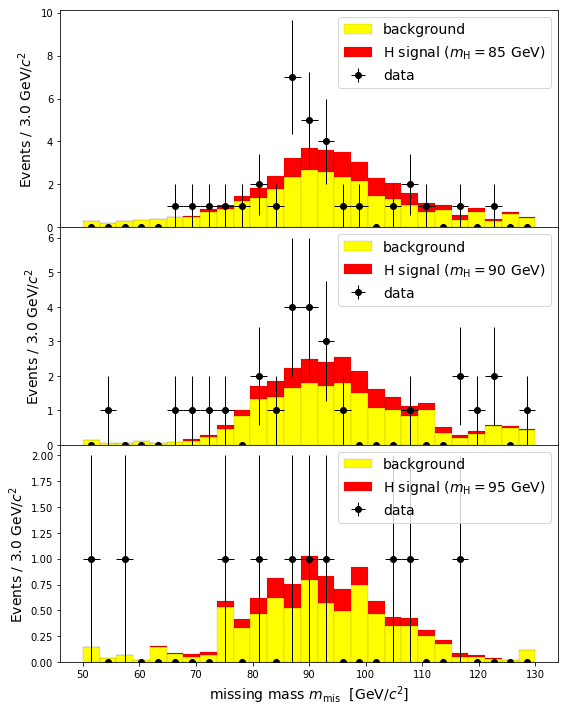

In [15]:
reload(pl)
pl.BkgSigHistos(background=bkg_histos,
                signals=sig_histos,
                data=data_histos,
                variable_binning=binning,
                x_label=[x_name,x_unit],
                savepath=None)#save_path)

## The Log-likelihood ratio we define to be

$$
    -2 \log (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \log \left( 1 + \frac{s_i(m_H)}{b_i} \right)
$$

In [20]:
import stats as stat
reload(stat)

<module 'stats' from 'stats.pyc'>

In [21]:
"""Nexp = 10000
llr_85 = stat.LogLikRatio(background=bkg,signal=sigModels[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio(background=bkg,signal=sigModels[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio(background=bkg,signal=sigModels[2],N_experiments=Nexp)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)
"""

Nexp = 10000
llr_85 = stat.LogLikRatio(background=bkg_histos[0],signal=sig_histos[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio(background=bkg_histos[1],signal=sig_histos[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio(background=bkg_histos[2],signal=sig_histos[2],N_experiments=Nexp)

llr_obs_85 = stat.LogLikRatioObserved(background=bkg_histos[0],signals=sig_histos,data=data_histos[0])[0]
llr_obs_90 = stat.LogLikRatioObserved(background=bkg_histos[1],signals=sig_histos,data=data_histos[1])[1]
llr_obs_95 = stat.LogLikRatioObserved(background=bkg_histos[2],signals=sig_histos,data=data_histos[2])[2]

llr_obs = [llr_obs_85,llr_obs_90,llr_obs_95]

In [25]:
path = '/home/janik/StatMethods/Project/plots/loglikeliratio/'
#ensure_dir(file_path=path)
save_path = None#path+variable

In [23]:
print llr_obs

[0.13933493201598779, -1.6663199496940955, -0.40486726723988298]


181
174
187


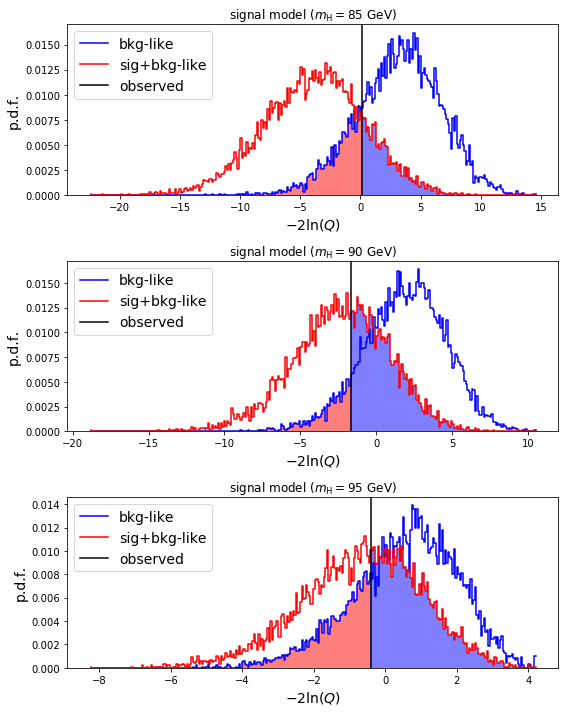

[[0.17499999999999999, 0.1802], [0.088099999999999998, 0.44490000000000002], [0.23540000000000005, 0.47069999999999979]]


In [24]:
reload(pl)
CLlist, Quantiles_b, Quantiles_sPlusb = pl.LogLikRatioPlots([llr_85,llr_90,llr_95],
                                                            Nbins=300,obs=llr_obs,
                                                            savepath=None#save_path
                                                           )
print CLlist

$$CL_s = \frac{CL_{s+b}}{CL_b} = \frac{CL_{s+b}}{1-(1-CL_b)}$$

In [35]:
CLs = [entry[1]/(1-entry[0]) for entry in CLlist]
print CLs

print "Confidence level CL >= "
for i in xrange(len(CLs)):
    print "    ", 1 - CLs[i]

[0.21399562636676042, 0.49648722179124394, 0.62213959556425302]
Confidence level CL >= 
     0.786004373633
     0.503512778209
     0.377860404436


# Quantile plot

In [36]:
print Quantiles_b[0]
print Quantiles_b[1]
print Quantiles_b[2]

#print Quantiles_sPlusb

[3.2402296383431661, [-0.23339013601329839, 6.5691152554347809], [-3.9964782248994695, 9.6085325579966891]]
[1.9159424371956497, [-0.788795691587449, 4.5240827756650646], [-3.7833271913115905, 6.8424297431934313]]
[0.60504462614623478, [-0.91035418047696481, 1.9310185819415331], [-2.6625340506350401, 3.0202114742019575]]


In [37]:
print Quantiles_b[:][0][0]

3.24022963834


In [38]:
MHiggs = np.array([85.,90.,95])

In [43]:
Quantiles_b = [[4.17450166378066, [0.36682136305160284, 7.6648752727822966], [-3.9168189752685834, 10.837942190056509]], [2.5979840592736423, [-0.46927828916865977, 5.3244394801112449], [-3.9909498744172254, 7.7100879733441445]], [0.70195337492436138, [-0.90642270726311835, 2.0884844802583942], [-2.7921050105174032, 3.2531706087389818]]]
Quantiles_sPlusb = [[-5.3446990880419776, [-10.738912847408141, -0.42644536626695029], [-16.609086644365437, 4.015848317916948]], [-3.0821314008046912, [-6.9446099136579615, 0.5531424936454421], [-11.261497663317497, 3.8476094604908759]], [-0.68457773040967318, [-2.6257212778773198, 0.9792595959911683], [-4.8441710464117724, 2.4212519455385628]]]

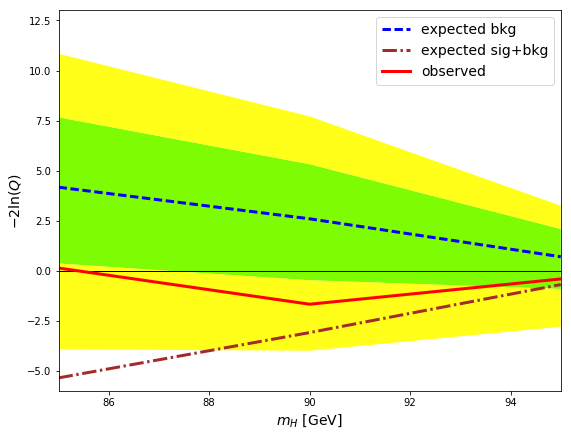

In [44]:
plt.figure(figsize=(9,7))



y_b = np.array([Quantiles_b[0][0],Quantiles_b[1][0],Quantiles_b[2][0]])
y_b_oneS_lower = np.array([Quantiles_b[0][1][0],Quantiles_b[1][1][0],Quantiles_b[2][1][0]])
y_b_oneS_upper = np.array([Quantiles_b[0][1][1],Quantiles_b[1][1][1],Quantiles_b[2][1][1]])


plt.plot(MHiggs,y_b,'b--',label='expected bkg',linewidth=3)


plt.fill_between(MHiggs, y_b_oneS_lower, y_b_oneS_upper,facecolor='lawngreen',alpha=0.99)




#plt.plot(MHiggs,[Quantiles_b[0][1][0],Quantiles_b[1][1][0],Quantiles_b[2][1][0]],'y-',color='lawngreen')
#plt.plot(MHiggs,[Quantiles_b[0][1][1],Quantiles_b[1][1][1],Quantiles_b[2][1][1]],'y-',color='lawngreen')


y_b_twoS_lower = np.array([Quantiles_b[0][2][0],Quantiles_b[1][2][0],Quantiles_b[2][2][0]])
y_b_twoS_upper = np.array([Quantiles_b[0][2][1],Quantiles_b[1][2][1],Quantiles_b[2][2][1]])

plt.fill_between(MHiggs, y_b_twoS_lower, y_b_oneS_lower,facecolor='yellow',alpha=0.9)
plt.fill_between(MHiggs, y_b_oneS_upper, y_b_twoS_upper,facecolor='yellow',alpha=0.9)


#plt.plot(MHiggs,[Quantiles_b[0][2][0],Quantiles_b[1][2][0],Quantiles_b[2][2][0]],'g-',color='yellow')
#plt.plot(MHiggs,[Quantiles_b[0][2][1],Quantiles_b[1][2][1],Quantiles_b[2][2][1]],'g-',color='yellow')





plt.plot(MHiggs,[Quantiles_sPlusb[0][0],Quantiles_sPlusb[1][0],Quantiles_sPlusb[2][0]],'-.',label='expected sig+bkg',
        color='brown',linewidth=3)


plt.plot(MHiggs,llr_obs,'r-',label='observed',linewidth=3)

plt.hlines(0,85,95,linewidth=1)

plt.xlim(85.,95.)
plt.ylim(-6,13)
plt.xlabel(r'$m_{H}$ [GeV]',fontsize=14)
plt.ylabel(r'$-2 \ln (Q)$',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig("./plots/quantile_plot_2D")
plt.show()

# 1 - $CL_b$ plots

In [45]:
def GetCLOneMinusb (array, cut) :
    hist, binning = np.histogram(array,bins=300)
    hist = hist / (1.*len(array))
     
    
    OneMinusCLb = []
    for c in cut :
        try :
            pos =  np.where(binning <= c)[0][-1]
            OneMinusCLb.append(sum(hist[:pos]))
        except :
            OneMinusCLb.append(0)
            
    return OneMinusCLb
    
    

In [47]:
N_b_pseudo_85 = [] 
N_pseudo_exp = 10000
N_sigPlusbkg_pseudo_85 = []
N_sigPlusbkg_pseudo_90 = []
N_sigPlusbkg_pseudo_95 = []

for i in xrange(N_pseudo_exp) :
    N_b_pseudo_85.append(np.random.poisson(lam=bkg_histos[0]))
    
    N_sigPlusbkg_pseudo_85.append(np.random.poisson(lam=sig_histos[0]+bkg_histos[0]))
    N_sigPlusbkg_pseudo_90.append(np.random.poisson(lam=sig_histos[1]+bkg_histos[1]))
    N_sigPlusbkg_pseudo_95.append(np.random.poisson(lam=sig_histos[2]+bkg_histos[2]))

    

In [48]:
llr_Pseudo_obs_85 = stat.LogLikRatioObserved(background=bkg_histos[0],signals=sig_histos,data=N_b_pseudo_85)[0]


llr_Pseudo_obs_sigPlusbkg_85 = stat.LogLikRatioObserved(background=bkg_histos[0],
                                                    signals=sig_histos,
                                                    data=N_sigPlusbkg_pseudo_85)[0]

llr_Pseudo_obs_sigPlusbkg_90 = stat.LogLikRatioObserved(background=bkg_histos[1],
                                                    signals=sig_histos,
                                                    data=N_sigPlusbkg_pseudo_90)[1]

llr_Pseudo_obs_sigPlusbkg_95 = stat.LogLikRatioObserved(background=bkg_histos[2],
                                                    signals=sig_histos,
                                                    data=N_sigPlusbkg_pseudo_95)[2]



In [49]:
#CL_omb = GetCLOneMinusb(array=llr_85[0],cut=llr_Pseudo_obs_85) 

CL_OneMinusCLb_sigPlusbkg_85 = GetCLOneMinusb(array=llr_85[0],cut=llr_Pseudo_obs_sigPlusbkg_85)
CL_OneMinusCLb_sigPlusbkg_90 = GetCLOneMinusb(array=llr_90[0],cut=llr_Pseudo_obs_sigPlusbkg_90)
CL_OneMinusCLb_sigPlusbkg_95 = GetCLOneMinusb(array=llr_95[0],cut=llr_Pseudo_obs_sigPlusbkg_95)


In [54]:
mean_85 = np.mean(CL_OneMinusCLb_sigPlusbkg_85)
mean_90 = np.mean(CL_OneMinusCLb_sigPlusbkg_90)
mean_95 = np.mean(CL_OneMinusCLb_sigPlusbkg_95)


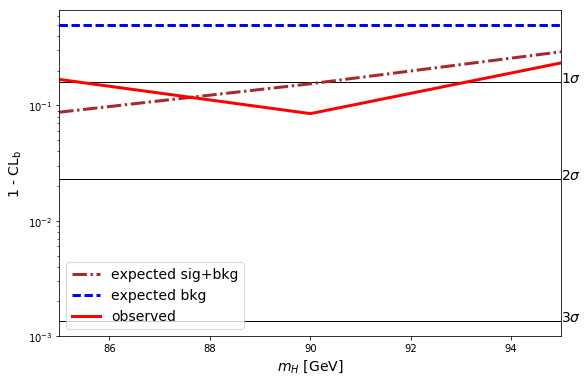

In [85]:
plt.figure(figsize=(9,6))

plt.plot(MHiggs,[mean_85,mean_90,mean_95],'-.',color='brown',label='expected sig+bkg',linewidth=3)
plt.plot(MHiggs,[0.5,0.5,0.5],'--',color='blue',label='expected bkg',linewidth=3)
plt.plot(MHiggs,[CLlist[0][0],CLlist[1][0],CLlist[2][0]],'r-',label='observed',linewidth=3)

plt.hlines(0.16,85,95,color='k',linewidth=1)
plt.text(95,0.16,r'$1 \sigma$',fontsize=14)
plt.hlines(0.023,85,95,color='k',linewidth=1)
plt.text(95,0.023,r'$2 \sigma$',fontsize=14)
plt.hlines(1.35*10**(-3),85,95,color='k',linewidth=1)
plt.text(95,1.35*10**(-3),r'$3 \sigma$',fontsize=14)

plt.semilogy()
plt.xlim(85,95)
plt.legend(fontsize=14,loc='best')
plt.xlabel(r'$m_{H}$ [GeV]',fontsize=14)
plt.ylabel(r'1 - CL${}_\mathrm{b}$',fontsize=14)

#plt.savefig("./plots/OneMinusCLb_plot")


plt.show()